In [ ]:
import numpy as np;
import pandas as pd;
import math as math;

from sklearn import discriminant_analysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer,roc_auc_score,precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
!pip install --upgrade scikit-learn
mccScorer = make_scorer(matthews_corrcoef)
roc_auc_scoreScorer=make_scorer(roc_auc_score)
from numpy import mean
from numpy import std

from google.colab import drive
drive.mount("/content/gdrive")

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_validate

Mounted at /content/gdrive


In [ ]:
#read training dataset 1
data1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_1_Training.csv')

X_train_actual_1=data1[:-2].T[1:].values

y_train_actual_1 = data1[-2:].T[-130:].T.values

In [ ]:
#read training dataset 2
data2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset_2_Training.csv')

X_train_actual_2=data2[:-4].T[1:].values

y_train_actual_2 = data2[-4:].T[-340:].T.values

In [ ]:
co1={'X':X_train_actual_1,'Y': y_train_actual_1[0]};
co2={'X':X_train_actual_1,'Y': y_train_actual_1[1]};

co3={'X':X_train_actual_2,'Y': y_train_actual_2[0]};
co4={'X':X_train_actual_2,'Y': y_train_actual_2[1]};
co5={'X':X_train_actual_2,'Y': y_train_actual_2[2]};
co6={'X':X_train_actual_2,'Y': y_train_actual_2[3]};

In [ ]:
def determine_number_of_top_features(X,Y):
  X=pd.DataFrame(X)
  X=X.astype(float)

  Y=pd.DataFrame(Y)
  Y=Y.astype(int)

  sel = f_classif(X, Y)
  p_values = pd.Series(sel[1])
  p_values.index = X.columns
  p_values.sort_values(ascending=True, inplace=True)
  p_values = p_values[p_values < 0.05]
  X_p = X[p_values.index]
  return X_p.shape[1]

In [ ]:
best_co1=determine_number_of_top_features(**co1)
best_co2=determine_number_of_top_features(**co2)
best_co3=determine_number_of_top_features(**co3)
best_co4=determine_number_of_top_features(**co4)
best_co5=determine_number_of_top_features(**co5)
best_co6=determine_number_of_top_features(**co6)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
def LDAClassifier_with_HPTuning(X,Y):
  # define model
  model = discriminant_analysis.LinearDiscriminantAnalysis()
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
  # define search space
  space = dict()
  space['solver'] = ['lsqr', 'eigen']
  space['shrinkage'] = ['auto']
  # define search
  search = GridSearchCV(model, space, scoring=mccScorer,cv=cv)
  # execute search
  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=1).transform(X);
  result = search.fit(X_selected_features, Y.astype('int'))
  # summarize result
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
LDAClassifier_with_HPTuning(**co1)

Best Score: 0.6608272320053145
Best Hyperparameters: {'shrinkage': 'auto', 'solver': 'lsqr'}


In [ ]:
LDAClassifier_with_HPTuning(**co2)

Best Score: 0.6992655451215437
Best Hyperparameters: {'shrinkage': 'auto', 'solver': 'lsqr'}


In [ ]:
LDAClassifier_with_HPTuning(**co3)

In [ ]:
def feature_selector(X,Y,numberOfFeaturesToBeSelected=1):
  if(numberOfFeaturesToBeSelected == 1):
    totalNumberOfFeatures=X.shape[1]
    numberOfFeaturesToBeSelected= totalNumberOfFeatures // 2
  # define feature selection
  fs = SelectKBest(score_func=f_classif, k=numberOfFeaturesToBeSelected)
  # apply feature selection
  return fs.fit(X, Y)

In [ ]:
def plot_PRC_for_CV(predictor,k_fold,X,y,label):
  f, axes = plt.subplots(1,1,squeeze=False)
  
  y_real = []
  y_proba = []
  
  for i, (train_index, test_index) in enumerate(k_fold.split(X,y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision, recall, _ = precision_recall_curve(ytest, pred_proba[:,1])
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
    axes[0,0].step(recall, precision, label=lab)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

  y_real = np.concatenate(y_real)
  y_proba = np.concatenate(y_proba)
  precision, recall, _ = precision_recall_curve(y_real, y_proba)
  lab = 'Overall AUC=%.4f' % (auc(recall, precision))
  axes[0,0].step(recall, precision, label=lab, lw=2, color='black')
  axes[0,0].set_xlabel('Recall')
  axes[0,0].set_ylabel('Precision')
  axes[0,0].legend(loc='lower left', fontsize='small')
  axes[0,0].set(title=label)

  # f.tight_layout()
  f.savefig(label+'.png')

In [ ]:
def plot_ROC_for_CV(classifier,cv,X,y,label):
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for i, (train, test) in enumerate(cv.split(X, y)):
      classifier.fit(X[train], y[train])
      viz = RocCurveDisplay.from_estimator(
          classifier,
          X[test],
          y[test],
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )

  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      title=label,
  )
  ax.legend(loc="lower right")
  plt.show()
  fig.savefig(label+'.png')

In [ ]:
def LDAClassifier_with_cross_val(X,Y,solver,shrinkage,endpointLabel,numberOfFeatures=1):
  # define model
  model = discriminant_analysis.LinearDiscriminantAnalysis(shrinkage= shrinkage, solver= solver)
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
  
  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}

  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X);
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-LDA-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-LDA-'+endpointLabel)

In [ ]:
LDAClassifier_with_cross_val(co1['X'],co1['Y'],'lsqr','auto','0.5-CO1')

MCC Score- Mean: 0.622 SD: (0.105)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [8.87453251e+02 3.11982632e-02 6.21915708e-01 8.53846154e-01
 7.48809524e-01 6.95238095e-01 7.13113553e-01 8.01040100e-01]
SD [5.43922263 0.00971612 0.10493964 0.04485348 0.15376971 0.02332847
 0.0669448  0.0292845 ]


MCC Score- Mean: 0.704 SD: (0.050)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [3.65613936e+01 2.18042850e-02 7.03606082e-01 8.84615385e-01
 8.08333333e-01 7.57142857e-01 7.70549451e-01 8.42518797e-01]
SD [0.48236352 0.00442324 0.0498761  0.02432521 0.12247449 0.07438333
 0.03131695 0.01717823]


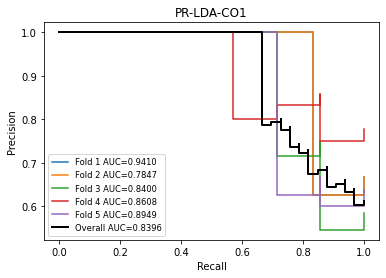

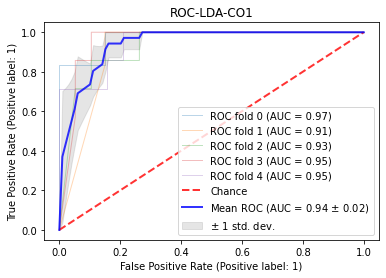

In [ ]:
LDAClassifier_with_cross_val(co1['X'],co1['Y'],'lsqr','auto','CO1',best_co1)

MCC Score- Mean: 0.641 SD: (0.174)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [9.89559398 0.01703386 0.64068617 0.82307692 0.79786325 0.77090909
 0.7757971  0.81503788]
SD [0.28271809 0.00455019 0.17403721 0.08284869 0.12584436 0.1434406
 0.10894811 0.08714242]


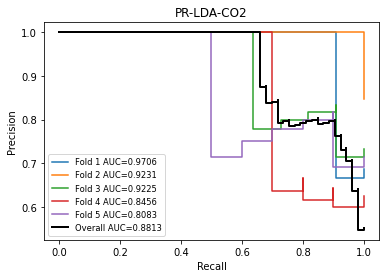

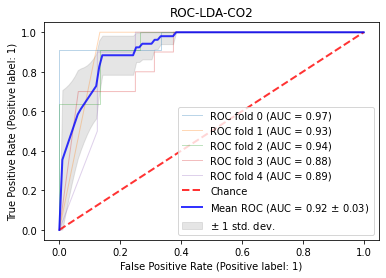

In [ ]:
LDAClassifier_with_cross_val(co2['X'],co2['Y'],'lsqr','auto','CO2',best_co2)

MCC Score- Mean: 0.541 SD: (0.033)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [4.50064191e+02 5.56802273e-02 5.41453222e-01 8.44117647e-01
 7.69300699e-01 5.17647059e-01 6.17910825e-01 7.33484163e-01]
SD [1.60351185 0.01201384 0.03257855 0.01176471 0.02836817 0.03989606
 0.03019343 0.01873325]


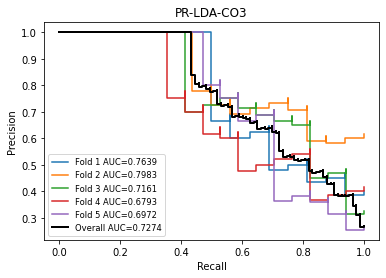

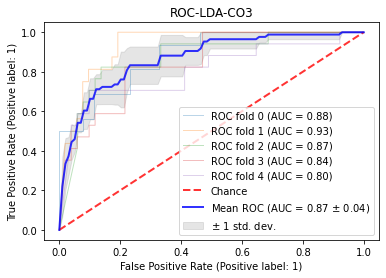

In [ ]:
LDAClassifier_with_cross_val(co3['X'],co3['Y'],'lsqr','auto','CO3',best_co3)

In [ ]:
LDAClassifier_with_cross_val(**co4)

233
MCC Score- Mean: 0.174 SD: (0.191)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [0.08312579 0.00892915 0.17399104 0.70882353 0.24632034 0.47
 0.31626802]
SD [0.02169739 0.0029289  0.1911993  0.07258213 0.11453633 0.25075442
 0.14864456]


In [ ]:
LDAClassifier_with_cross_val(**co5)

233
MCC Score- Mean: 0.649 SD: (0.115)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [0.08476225 0.00851443 0.64852303 0.82647059 0.80664307 0.7902381
 0.79506263]
SD [0.02076016 0.00220578 0.11514477 0.05494571 0.07815334 0.09253883
 0.06739613]


In [ ]:
LDAClassifier_with_cross_val(**co6)

233
MCC Score- Mean: 0.200 SD: (0.195)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [0.08880847 0.00912921 0.19959152 0.60735294 0.67557818 0.645
 0.65631289]
SD [0.024288   0.00311389 0.19512428 0.09633195 0.09246951 0.115
 0.09371838]


In [ ]:
def QDAClassifier_with_cross_val(X,Y,endpointLabel,numberOfFeatures=1):
  # define model
  model = discriminant_analysis.QuadraticDiscriminantAnalysis()
  # define evaluation
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

  scoringReports={'mccScorer': mccScorer,'accuracy': 'accuracy','precision':'precision','recall':'recall', 'f1':'f1','ruc_auc':roc_auc_scoreScorer}

  X_selected_features=feature_selector(X,Y,numberOfFeaturesToBeSelected=numberOfFeatures).transform(X);
  scores = cross_validate(model,X_selected_features , Y.astype('int'), scoring=scoringReports, cv=cv)

  # summarize result
  print('MCC Score- Mean: %.3f SD: (%.3f)' % (mean(scores['test_mccScorer']), std(scores['test_mccScorer'])))
  print(list(scores.keys()))
  print("Means",mean(list(scores.values()),axis=1))
  print("SD",std(list(scores.values()),axis=1))
  plot_PRC_for_CV(model,cv,X_selected_features,Y.astype('int'),'PR-QDA-'+endpointLabel)
  plot_ROC_for_CV(model,cv,X_selected_features,Y.astype('int'),'ROC-QDA-'+endpointLabel)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


MCC Score- Mean: 0.005 SD: (0.263)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_ruc_auc']
Means [0.11516299 0.02733803 0.00458794 0.60769231 0.26444444 0.28095238
 0.26819347 0.50073935]
SD [0.00905344 0.01305572 0.26298327 0.11252876 0.19930744 0.18467352
 0.18616483 0.1271206 ]


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

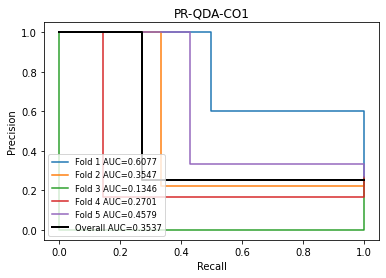

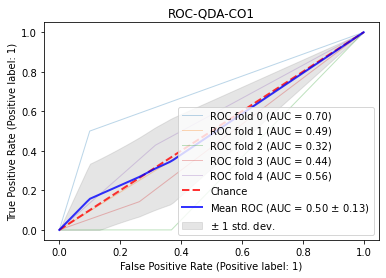

In [ ]:
QDAClassifier_with_cross_val(co1['X'],co1['Y'],'CO1',best_co1)

In [ ]:
QDAClassifier_with_cross_val(**co2)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

MCC Score- Mean: 0.044 SD: (0.260)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [0.57621529 0.02962832 0.04445208 0.53076923 0.43011905 0.46166667
 0.4330772 ]
SD [0.01559831 0.00180937 0.25981519 0.11892019 0.15453514 0.21737704
 0.15728858]


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
QDAClassifier_with_cross_val(**co3)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

MCC Score- Mean: 0.023 SD: (0.161)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [7.34035594 0.15225501 0.02284394 0.6        0.25656628 0.34236111
 0.28789291]
SD [0.18341588 0.00560319 0.16060951 0.07347056 0.08649593 0.16668258
 0.1076071 ]


In [ ]:
QDAClassifier_with_cross_val(**co4)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

MCC Score- Mean: 0.040 SD: (0.174)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [7.51321163 0.16061058 0.04005449 0.68823529 0.17168831 0.29333333
 0.21343066]
SD [0.18712804 0.00589615 0.17365522 0.06668108 0.1151219  0.19961073
 0.13938802]


In [ ]:
QDAClassifier_with_cross_val(**co5)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

MCC Score- Mean: 0.013 SD: (0.183)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [7.38217911 0.15505247 0.012993   0.51617647 0.43386008 0.44261905
 0.43492258]
SD [0.15819503 0.00569312 0.1830555  0.0894403  0.10108549 0.13942281
 0.11557726]


In [ ]:
QDAClassifier_with_cross_val(**co6)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.7/dist-packages/sklearn/discriminan

MCC Score- Mean: -0.020 SD: (0.164)
['fit_time', 'score_time', 'test_mccScorer', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1']
Means [ 7.67316228  0.15123744 -0.02014459  0.50735294  0.58100023  0.5875
  0.58173905]
SD [0.19516131 0.00542916 0.16441014 0.07994105 0.07049094 0.10108783
 0.07498698]
